In [2]:
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import jax.scipy.stats as stats
from jax import jacfwd, jacrev
from jax import vmap, grad, jit, random
from jax.tree_util import tree_map, tree_flatten, tree_unflatten, tree_leaves

from flax import nnx
import optax
import pcax

from tqdm.notebook import tqdm
from tqdm.notebook import trange

import torch
import torch.nn as nn
import torch_harmonics as th
from torch_harmonics.random_fields import GaussianRandomFieldS2
from torch.utils.data import DataLoader, TensorDataset

import os
os.chdir('../methods')
import lsci, supr, conf, uqno, prob_don, quant_don, gaus
os.chdir('../gpsims')

os.chdir('../models_and_metrics')
from models import *
from metrics import * 
from utility import *
os.chdir('../gpsims')

import neuralop as op
from neuralop.models import FNO, LocalFNO, UNO, TFNO
import jaxwt as jwt
import pcax
from jax.scipy.stats import norm, laplace

In [3]:
def phi_depth(z, x, w, depth_fn):
    if depth_fn == 'tukey':
        f = jnp.sum(w[:,None] * (z > x), axis = 0)
        depth_1d = 1 - jnp.abs(1 - 2 * f)
    
    elif depth_fn == 'mahal':
        mu = jnp.sum(w[:,None]*x, axis = 0)
        sig = jnp.sqrt(jnp.sum((w[:,None]*x - mu)**2, axis = 0))
        depth_1d = 1/(1+jnp.sqrt((z - mu)**2/sig**2))
        
    elif depth_fn == 'norm':
        norms = jnp.abs(z - x)
        wnorm = jnp.sum(w[:,None] * norms, axis = 0)
        depth_1d = 1/(1+wnorm)

    else: return 0
    return jnp.min(depth_1d)

phi_depth = jit(phi_depth, static_argnames='depth_fn')
vphi_depth = jit(vmap(phi_depth, (0, None, None, None)), static_argnames='depth_fn')

def phi_slice(rng, p1, p2):
    phi = random.normal(rng, (p1, p2))
    phi = phi / jnp.sum(phi, axis = 1)[:,None]
    return phi

def lweights(xval, xtest, frac = 0.1):
    dmat = jnp.max(jnp.abs(xval - xtest), axis = 1)
    quant = jnp.quantile(dmat, frac, axis = 0)
    indx = dmat < quant
    inner_max = jnp.max(dmat * indx)
    dmat = inner_max - dmat
    w = dmat * indx
    return w / jnp.sum(w, axis = 0)[None,]
lweights = jit(vmap(lweights, (None, 0, None)))


def localizer(xval, xtest, lam, local_fn, rng):
    if local_fn == 'dexp':
        xtil = xtest[None,] + 1e-2 * jax.random.normal(rng, xtest[None,].shape)
        dist = jnp.exp(-lam * jnp.max(jnp.abs(xval - xtil), axis = (1, 2)))
        local_weights = dist / (jnp.sum(dist) + jnp.exp(-lam * 1e-2))
        
    elif local_fn == 'gaussian':
        xtil = xtest[None,] + 1e-2 * jax.random.normal(rng, xtest[None,].shape)
        dist = jnp.exp(-lam * jnp.mean((xval - xtil)**2, axis = (1, 2)))
        local_weights = dist / (jnp.sum(dist) + jnp.exp(-lam * 1e-2))
        
    elif local_fn == 'knn':
        xtil = xtest[None,] + 1e-2 * jax.random.normal(rng, xtest[None,].shape)
        dist = jnp.max(jnp.abs(xval - xtil), axis = (1, 2))
        qdist = jnp.quantile(dist, lam)
        dist = jnp.exp(-dist.at[dist > qdist].set(jnp.inf))
        local_weights = dist / (jnp.sum(dist) + 1)
        
    else :
        local_weights = 1/xval.shape[0]
    return local_weights

def phi_quantile(rval_phi, xval, xtest, alpha, depth_fn, local_fn, lam, rng):
    
#     xtil = xtest[None,] + 1e-2 * jax.random.normal(rng, xtest[None,].shape)
#     dist = jnp.exp(-lam * jnp.max(jnp.abs(xval - xtil), axis = (1, 2)))
#     local_weights = dist / (jnp.sum(dist) + jnp.exp(-lam * 1e-2))

    local_weights = localizer(xval, xtest, lam, local_fn, rng)
    dval = vphi_depth(rval_phi, rval_phi, local_weights, depth_fn)
    
    n = xval.shape[0]
    adj_alpha = jnp.ceil((n+1)*(1-alpha))/n
    return jnp.quantile(dval, 1-adj_alpha), local_weights
# phi_quantile = jit(phi_quantile, static_argnames=['depth_fn', 'local_fn'])


def phi_resample(xval, xtest, rval_phi, n_samp, n_slice, rng,
                 alpha, depth_fn, local_fn, lam):
    n = rval_phi.shape[0]
    npc = rval_phi.shape[1]
    key1, key2, key3 = random.split(rng, 3)
    local_weights = lweights(xval.squeeze(), xtest.squeeze()[None,], 0.1)[0]
    
    unif = random.uniform(key1, (n_samp, npc))
    quants = jnp.linspace(jnp.min(rval_phi) - 0.1, jnp.max(rval_phi) + 0.1, n+1)

    samp_cdfs = lsci.lcdf(rval_phi, quants, local_weights / jnp.sum(local_weights))
    samp_quants = jnp.argmax(samp_cdfs[:,:,None] > unif.T[None,:,:], axis = 0)
    samp_phi = quants[samp_quants].T
    
    phi = phi_slice(key2, npc, n_slice)
    qval, local_weights = phi_quantile(rval_phi @ phi, xval, xtest, alpha, depth_fn, local_fn, lam, rng = key3)
    dphi = vphi_depth(samp_phi @ phi, rval_phi @ phi, local_weights, depth_fn)
    
    return samp_phi, dphi, qval

In [4]:
def uqno_lambda(yval, yval_hat, yval_quant, delta, alpha):
    n = yval.shape[0]
    m = yval.shape[1]
    tau = 1e-2 + jnp.sqrt(-jnp.log(delta)/(2*m))
    
    uqno_scores = jnp.abs(yval.squeeze() - yval_hat) / yval_quant
    sg = jnp.quantile(uqno_scores, jnp.clip(1-alpha+tau, 0, 1), axis = 1)
    q = 1 - jnp.ceil((n+1)*(delta - jnp.exp(-2*m*tau**2)))/n
    return jnp.quantile(sg, q)

def prob_don(yval, yval_mu, yval_sd, ytest_sd, alpha):
    nval = yval.shape[0]
    alpha_adj = jnp.ceil((1-alpha) * (nval + 1))/nval
    
    score = jnp.abs(yval - yval_mu)/yval_sd
    q = jnp.quantile(score, alpha_adj, axis = 0)
    
    lower = -ytest_sd * q[None,]
    upper = ytest_sd * q[None,]
    return lower, upper

def quant_don(yval, yval_quant, ytest_quant, alpha):
    
    nval = yval.shape[0]
    alpha_adj = jnp.ceil((1-alpha) * (nval + 1))/nval
    
    lower = -yval_quant - yval
    upper = yval - yval_quant
    score = jnp.max(jnp.stack([lower, upper], axis = 2), axis=2)
    q = jnp.quantile(score, alpha_adj, axis = 0)
    
    lower = -ytest_quant - q[None,]
    upper = ytest_quant + q[None,]
    return lower, upper

In [5]:
class QuantileLoss(nn.Module):
    def __init__(self, quantile):
        super().__init__()
        self.quantile = quantile

    def forward(self, y_hat, y):
        res = y - y_hat
        return torch.mean(torch.max((self.quantile - 1) * res, self.quantile * res))
    
class GaussianNLLLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, outputs, y):
        mu, sd = outputs
        nll = 0.5 * torch.log(2 * torch.pi * sd**2) + 0.5*(y - mu)**2 / sd**2
        return nll.mean()
    
class ProbFNO(nn.Module):
    def __init__(self):
        super().__init__()
        self.mu_fno = FNO(n_modes=(16,32), hidden_channels=64, in_channels=1, out_channels=1)
        self.sd_fno = FNO(n_modes=(16,32), hidden_channels=64, in_channels=1, out_channels=1)

    def __call__(self, x):
        mu = self.mu_fno(x)
        log_sd = self.sd_fno(x)
        return mu, torch.nn.Softplus()(log_sd)

In [6]:
dtrain = np.load('../data/era5_train_small.npy', mmap_mode='r+')
nlat, nlon = dtrain.shape[1:]
dtrain = np.mean(dtrain.reshape(-1, 4, nlat, nlon), axis = 1)

# train_mu = np.mean(dtrain, axis = (0))[None,]
# train_sd = np.std(dtrain, axis = (0))[None,]

def clim_smooth(data, kernel):
    return jax.scipy.signal.convolve2d(data, kernel, mode='same')
clim_smooth = jit(vmap(clim_smooth, (0, None)))

kernel = jnp.array([[1, 1, 1], [1, 5, 1], [1, 1, 1]])
kernel = kernel / jnp.sum(kernel)
dtrain = np.array(clim_smooth(dtrain, kernel))

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
lag, lead = 1, 1
xtrain, ytrain = split_data(dtrain, lag, lead)
train_data = TensorDataset(torch.Tensor(xtrain), torch.Tensor(ytrain))
train_loader = DataLoader(train_data, batch_size = 64, shuffle = True)

In [9]:
loss_fn = nn.MSELoss()
epochs = 20

fno = FNO(n_modes=(16,32), 
             hidden_channels=64, 
             in_channels=1, 
             out_channels=1)
fno.to(device)
optim_fno = torch.optim.Adam(fno.parameters(), lr = 1e-3)

for _ in trange(epochs):
    for xt, yt in tqdm(train_loader, leave = False):
        xt = xt.to(device)
        yt = yt.to(device)
        yhat = fno(xt)
        loss = loss_fn(yhat, yt)
        loss.backward()
        optim_fno.step()
        optim_fno.zero_grad()


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

In [10]:
loss_fn = QuantileLoss(0.9)

fno_quant = FNO(n_modes=(16,32), 
             hidden_channels=64, 
             in_channels=1, 
             out_channels=1)
fno_quant.to(device)
optim_fno = torch.optim.Adam(fno_quant.parameters(), lr = 1e-3)

for _ in trange(epochs):
    for xt, yt in tqdm(train_loader, leave = False):
        xt = xt.to(device)
        yt = yt.to(device)
        yhat = fno_quant(xt)
        loss = loss_fn(yhat, yt)
        loss.backward()
        optim_fno.step()
        optim_fno.zero_grad()

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

In [11]:
loss_fn = GaussianNLLLoss()

fno_prob = ProbFNO()
fno_prob.to(device)
optim_fno = torch.optim.Adam(fno_prob.parameters(), lr = 1e-3)

for _ in trange(epochs):
    for xt, yt in tqdm(train_loader, leave = False):
        xt = xt.to(device)
        yt = yt.to(device)
        yhat = fno_prob(xt)
        loss = loss_fn(yhat, yt)
        loss.backward()
        optim_fno.step()
        optim_fno.zero_grad()

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

In [12]:
n = xtrain.shape[0]
xtrain_base1 = xtrain[:(n//2)]
ytrain_base1 = ytrain[:(n//2)]
xtrain_base2 = xtrain[(n//2):]
ytrain_base2 = ytrain[(n//2):]

train_data1 = TensorDataset(jax2torch(xtrain_base1), jax2torch(ytrain_base1))
train_loader1 = DataLoader(train_data1, batch_size = 30, shuffle = True)

train_data2 = TensorDataset(jax2torch(xtrain_base2), torch.abs(jax2torch(ytrain_base2)))
train_loader2 = DataLoader(train_data2, batch_size = 30, shuffle = False)

In [13]:
loss_fn = nn.MSELoss()
fno_base = FNO(n_modes=(16,32), 
             hidden_channels=64, 
             in_channels=1, 
             out_channels=1)
fno_base.to(device)
optim_fno = torch.optim.Adam(fno_base.parameters(), lr = 1e-3)

for _ in trange(epochs):
    for xt, yt in tqdm(train_loader1, leave = False):
        xt = xt.to(device)
        yt = yt.to(device)
        yhat = fno_base(xt)
        loss = loss_fn(yhat, yt)
        loss.backward()
        optim_fno.step()
        optim_fno.zero_grad()

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

In [14]:
ytrain_base1_hat = []
with torch.no_grad():
    for xt, yt in tqdm(train_loader2, leave = False):
        yt_hat = fno_base(xt.to(device)).cpu().squeeze()
        
        ytrain_base1_hat.append(yt_hat)
ytrain_base1_hat = torch.vstack(ytrain_base1_hat)[:,None]
ytrain_base1_hat = torch2jax(ytrain_base1_hat)

train_data2 = TensorDataset(jax2torch(xtrain_base2), torch.abs(jax2torch(ytrain_base2 - ytrain_base1_hat)))
train_loader2 = DataLoader(train_data2, batch_size = 30, shuffle = True)

  0%|          | 0/61 [00:00<?, ?it/s]

In [15]:
loss_fn = QuantileLoss(0.9)
fno_quant2 = FNO(n_modes=(16,32), 
             hidden_channels=64, 
             in_channels=1, 
             out_channels=1)
fno_quant2.to(device)
optim_fno = torch.optim.Adam(fno_quant2.parameters(), lr = 1e-3)

epochs = 20
for _ in trange(epochs):
    for xt, yt in tqdm(train_loader2, leave = False): 
        xt = xt.to(device)
        yt = yt.to(device)
        yhat = fno_quant2(xt)
        loss = loss_fn(yhat, yt)
        loss.backward()
        optim_fno.step()
        optim_fno.zero_grad()

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

In [16]:
# del dtrain, xtrain, ytrain
dval = np.load('../data/era5_val_small.npy', mmap_mode='r+')
dtest = np.load('../data/era5_test_small.npy', mmap_mode='r+')

dval = np.mean(dval.reshape(-1, 4, nlat, nlon), axis = 1)
dtest = np.mean(dtest.reshape(-1, 4, nlat, nlon), axis = 1)

dval = np.array(clim_smooth(dval, kernel))
dtest = np.array(clim_smooth(dtest, kernel))

xval, yval = split_data(dval, lag, lead)
xtest, ytest = split_data(dtest, lag, lead)

In [17]:
val_data = TensorDataset(jax2torch(xval), jax2torch(yval))
val_loader = DataLoader(val_data, batch_size = 30, shuffle = True)

test_data = TensorDataset(jax2torch(xtest), jax2torch(ytest))
test_loader = DataLoader(test_data, batch_size = 30, shuffle = False)

In [18]:
with torch.no_grad():
    yval_fno = []
    yval_quant = []
    yval_mu = []
    yval_sd = []
    yval_hat2 = []
    yval_quant2 = []

    ytest_fno = []
    ytest_quant = []
    ytest_mu = []
    ytest_sd = []
    ytest_hat2 = []
    ytest_quant2 = []
    
    for xt, _ in tqdm(val_loader, leave = False):
        xt = jax2torch(xt).to(device)
        
        yval_fno.append(fno(xt).cpu().squeeze())
        yval_quant.append(fno_quant(xt).cpu().squeeze())
        yval_mut, yval_sdt = fno_prob(xt)
        yval_mu.append(yval_mut.cpu().squeeze())
        yval_sd.append(yval_sdt.cpu().squeeze())
        yval_hat2.append(fno_base(xt).cpu().squeeze())
        yval_quant2.append(fno_quant2(xt).cpu().squeeze())
        
    yval_fno = torch2jax(torch.vstack(yval_fno)[:,None])
    yval_quant = torch2jax(torch.vstack(yval_quant)[:,None])
    yval_mu = torch2jax(torch.vstack(yval_mu)[:,None])
    yval_sd = torch2jax(torch.vstack(yval_sd)[:,None])
    yval_hat2 = torch2jax(torch.vstack(yval_hat2)[:,None])
    yval_quant2 = torch2jax(torch.vstack(yval_quant2)[:,None])

    for xt, _ in tqdm(test_loader, leave = False):
        xt = jax2torch(xt).to(device)
        
        ytest_fno.append(fno(xt).cpu().squeeze())
        ytest_quant.append(fno_quant(xt).cpu().squeeze())
        ytest_mut, ytest_sdt = fno_prob(xt)
        ytest_mu.append(ytest_mut.cpu().squeeze())
        ytest_sd.append(ytest_sdt.cpu().squeeze())
        ytest_hat2.append(fno_base(xt).cpu().squeeze())
        ytest_quant2.append(fno_quant2(xt).cpu().squeeze())

    ytest_fno = torch2jax(torch.vstack(ytest_fno)[:,None])
    ytest_quant = torch2jax(torch.vstack(ytest_quant)[:,None])
    ytest_mu = torch2jax(torch.vstack(ytest_mu)[:,None])
    ytest_sd = torch2jax(torch.vstack(ytest_sd)[:,None])
    ytest_hat2 = torch2jax(torch.vstack(ytest_hat2)[:,None])
    ytest_quant2 = torch2jax(torch.vstack(ytest_quant2)[:,None])

rval_fno = yval - yval_fno
rtest_fno = ytest - ytest_fno
rtest_fno2 = ytest - ytest_hat2
# _, nlat, nlon = rval_fno.shape

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

In [19]:
rval_fno = rval_fno.reshape(-1, nlat*nlon)
rtest_fno = rtest_fno.reshape(-1, nlat*nlon)

yval_quant = yval_quant.reshape(-1, nlat*nlon)
yval_hat2 = yval_hat2.reshape(-1, nlat*nlon)
yval_quant2  = yval_quant2.reshape(-1, nlat*nlon)
ytest_quant2  = ytest_quant2.reshape(-1, nlat*nlon)

yval = yval.reshape(-1, nlat*nlon)
yval_mu = yval_mu.reshape(-1, nlat*nlon)
yval_sd = yval_sd.reshape(-1, nlat*nlon)
ytest_sd  = ytest_sd.reshape(-1, nlat*nlon)
ytest_quant  = ytest_quant.reshape(-1, nlat*nlon)

In [70]:
nproj = nlat*nlon
nslice = nproj//10
nsamp = 2000
alpha = 0.1

# setup
pca_state = pcax.fit(rval_fno, nproj)
phi = phi_slice(random.PRNGKey(0), rval_fno.shape[1], nproj)
rval_phi = rval_fno @ phi
rval_fpc = pcax.transform(pca_state, rval_fno)

rval_quant = jnp.abs(rval_fno) / yval_quant

In [21]:
conf_lower, conf_upper = conf.conf_band(rval_fno, pca_state, alpha)
gaus_lower, gaus_upper = gaus.gaus_band(rval_fno, pca_state, alpha)
supr_lower, supr_upper = supr.supr_band(rval_fno, alpha)

uqno_lam = uqno_lambda(yval, yval_hat2, yval_quant2, delta = 0.1, alpha = 0.1)
uqn1_lower, uqn1_upper = -uqno_lam*ytest_quant2, uqno_lam*ytest_quant2

In [22]:
pdon_lower, pdon_upper = prob_don(yval.squeeze(), yval_mu, yval_sd, ytest_sd, alpha)
qdon_lower, qdon_upper = quant_don(yval.squeeze(), yval_quant, ytest_quant, alpha)

In [75]:
rng = random.PRNGKey(0)
ntest = ytest.shape[0]
nmod = 2 + 6
cover = np.zeros((ntest, nmod))
width = np.zeros((ntest, nmod))

for k in trange(0, ntest):
    
    ## LSCI 1
    rng, key1, key2 = random.split(rng, 3)
    local_ens, dphi, qval = phi_resample(xval.reshape(-1, 1, nlat*nlon), 
                                         xtest[k].reshape(1, nlat*nlon), 
                                         rval_fpc, 
                                         nsamp, nproj, key1,
                                         alpha, 'norm', 'knn', 0.01)
    local_ens = pcax.recover(pca_state, local_ens)
    local_ens = local_ens[dphi > qval]

    uval = jnp.max(local_ens, axis = 0)
    lval = jnp.min(local_ens, axis = 0)
    cover[k, 0] = risk(lval, uval, rtest_fno[k])
    width[k, 0] = np.median(uval - lval)
    
    ## LSCI 2
    local_ens, dphi, qval = phi_resample(xval.reshape(-1, 1, nlat*nlon), 
                                         xtest[k].reshape(1, nlat*nlon), 
                                         rval_fpc, 
                                         nsamp, nslice, key1,
                                         alpha, 'tukey', 'gaussian', 1)
    local_ens = pcax.recover(pca_state, local_ens)
    local_ens = local_ens[dphi > qval]

    uval = jnp.max(local_ens, axis = 0)
    lval = jnp.min(local_ens, axis = 0)
    cover[k, 1] = risk(lval, uval, rtest_fno[k])
    width[k, 1] = np.median(uval - lval)
    
    # CONF 
    cover[k, 2] = risk(conf_lower, conf_upper, rtest_fno[k])
    width[k, 2] = jnp.median(conf_upper - conf_lower)
    
    # GAUSS 
    cover[k, 3] = risk(gaus_lower, gaus_upper, rtest_fno[k])
    width[k, 3] = jnp.median(gaus_upper - gaus_lower)
    
    # SUPR
    cover[k, 4] = risk(supr_lower, supr_upper, rtest_fno[k])
    width[k, 4] = jnp.median(supr_upper - supr_lower)
    
    # UQNO
    cover[k, 5] = risk(uqn1_lower[k], uqn1_upper[k], rtest_fno[k])
    width[k, 5] = jnp.median(uqn1_upper[k] - uqn1_lower[k])
    
    # PDON
    cover[k, 6] = risk(pdon_lower[k], pdon_upper[k], rtest_fno[k])
    width[k, 6] = jnp.median(pdon_upper[k] - pdon_lower[k])
    
    # QDON
    cover[k, 7] = risk(qdon_lower[k], qdon_upper[k], rtest_fno[k])
    width[k, 7] = jnp.median(qdon_upper[k] - qdon_lower[k])

  0%|          | 0/1824 [00:00<?, ?it/s]

E0426 22:21:00.241673   29228 hlo_lexer.cc:443] Failed to parse int literal: 75240990185135123469173


ValueError: zero-size array to reduction operation max which has no identity

In [ ]:
for k in trange(20):
    
    ## LSCI 1
    rng, key1, key2 = random.split(rng, 3)
    local_ens, dphi, qval = phi_resample(xval.reshape(-1, 1, nlat*nlon), 
                                         xtest[k].reshape(1, nlat*nlon), 
                                         rval_fpc, 
                                         nsamp, nproj, key1,
                                         alpha, 'tukey', 'gaussian', 2)
    local_ens = pcax.recover(pca_state, local_ens)
    local_ens = local_ens[dphi > qval]

    uval = jnp.max(local_ens, axis = 0)
    lval = jnp.min(local_ens, axis = 0)
    cover[k, 0] = risk(lval, uval, rtest_fno[k])
    width[k, 0] = np.median(uval - lval)

In [64]:
local_ens.shape

(2000, 2048)

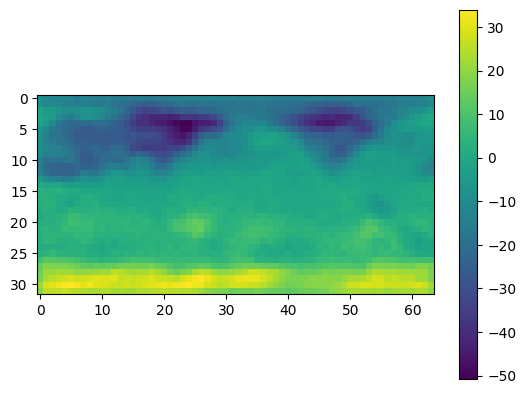

In [65]:
plt.imshow(local_ens[2].reshape(nlat,nlon))
plt.colorbar()

In [ ]:
# metrics
# sigma = sd[1:
sigma = jnp.mean(rtest_fno**2, axis = 1)
cover_mean = np.round(np.mean(cover > 0.99, axis = 0), 3)
width_mean = np.round(np.mean(width, axis = 0), 3)

## correlations
cover_corr_mean = np.zeros(nmod)
cover_corr_std = np.zeros(nmod)
width_corr_mean = np.zeros(nmod)
width_corr_std = np.zeros(nmod)
for i in range(nmod):
    corr = np.corrcoef(np.vstack([cover[:,i] > 0.99, sigma]))[0,1]
    cover_corr_mean[i] = np.mean(corr)
#     cover_corr_std[i] = 2*np.std(corr)
    
    corr = np.corrcoef(np.vstack([width[:,i], sigma]))[0,1]
    width_corr_mean[i] = np.mean(corr)
    width_corr_std[i] = 2*np.std(corr)

metrics_mean = np.vstack([
    cover_mean,
    cover_corr_mean,
    width_mean,
    width_corr_mean
]).T

In [ ]:
for i in range(nmod):
    for j in range(4):
        spacer = '& ' if j < 3 else '\\\\'
        endline = '' if j < 3 else '\n'
        
        result = metrics_mean[i, j]
        met = f'{result:.3f}' if not np.isnan(result) else '--'
        print(met, spacer, end=endline)